# BERT Triplet model training
## Dataset: TREC
---

## import

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

import pandas as pd
import tensorboard
from sklearn.model_selection import train_test_split

# triplet
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

## resources (config)

In [2]:
# OUTPUT: 저장될 경로, 모델명, 버전 정보
output_dir = 'output' # encoder 모델, log 저장할 상위 폴더
model_name = 'TRI_SUM_TREC_42'
version = 'v2.3'

# INPUT: 불러올 BERT base 모델, 데이터 경로
model_ckpt = 'pre-trained_BERT/uncased_L-12_H-768_A-12' # ckpt, vocab 들어있는 폴더 (구글 공식 제공)
dataset = 'dataset/trec' # 데이터 폴더

# epoch 및 batch_size 설정
epoch = 40
batch_size = 32

# dataset 및 loss 설정
dataset_type = 'TREC_42' # TREC_6 / TREC_42
loss_type = 'TRI' # TRI / COS_OHOT / COS_OMNS

In [3]:
# 폴더 미존재 시 자동 생성함
model_dir = output_dir + '/' + model_name + '/' + version + '/models' # model 저장할 폴더
log_dir = output_dir + '/' + model_name + '/' + version + '/logs'# log 저장할 폴더

print('==== OUTPUT 경로 ====')
print('model path:', model_dir)
print('log path:', log_dir)

tf.get_logger().setLevel('FATAL')

==== OUTPUT 경로 ====
model path: output/TRI_SUM_TREC_42/v2.3/models
log path: output/TRI_SUM_TREC_42/v2.3/logs


## callback

In [4]:
model_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         bert_classifier.save_weights(model_dir+'/classifier/%d/'%(epoch + 1))
        checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=bert_encoder_tri)
        path = checkpoint.write(model_dir+"/encoder/%d/ckpt"%(epoch + 1))

## datasets

In [5]:
# df 불러오기
temp_train_df = pd.read_csv(dataset+'/trec_train_5500.csv')
test_df = pd.read_csv(dataset+'/trec_test.csv')

In [6]:
if dataset_type == 'TREC_6':
    # 6개짜리로 index 수정
    temp_train_df['Class Index'] = temp_train_df['Class Index'].str.split(':').str[0]
    test_df['Class Index'] = test_df['Class Index'].str.split(':').str[0]

elif dataset_type == 'TREC_42':
    # 클래스 개수 파악
    num_classes = len(temp_train_df['Class Index'].unique())
    print('class개수: %d개'%num_classes)
    print('class목록:',list(temp_train_df['Class Index'].unique()))

    # test에 없는 클래스 파악
    test_list = list(test_df['Class Index'].unique())
    remove_label = []

    for label in list(temp_train_df['Class Index'].unique()):
        if label not in test_list:
            print(label)
            remove_label.append(label)
            
    # test에 없는 클래스 제거
    for remove in remove_label:
        temp_train_df = temp_train_df[temp_train_df['Class Index'] != remove]

    temp_train_df
    
else:
    raise Exception('잘못된 데이터 셋 입력')

class개수: 50개
class목록: ['DESC:manner', 'ENTY:cremat', 'ENTY:animal', 'ABBR:exp', 'HUM:ind', 'HUM:gr', 'HUM:title', 'DESC:def', 'NUM:date', 'DESC:reason', 'ENTY:event', 'LOC:state', 'DESC:desc', 'NUM:count', 'ENTY:other', 'ENTY:letter', 'LOC:other', 'ENTY:religion', 'ENTY:food', 'LOC:country', 'ENTY:color', 'ENTY:termeq', 'LOC:city', 'ENTY:body', 'ENTY:dismed', 'LOC:mount', 'NUM:money', 'ENTY:product', 'NUM:period', 'ENTY:substance', 'ENTY:sport', 'ENTY:plant', 'ENTY:techmeth', 'NUM:volsize', 'HUM:desc', 'ENTY:instru', 'ABBR:abb', 'NUM:other', 'NUM:speed', 'ENTY:word', 'ENTY:lang', 'NUM:perc', 'NUM:code', 'NUM:dist', 'NUM:temp', 'ENTY:symbol', 'NUM:ord', 'ENTY:veh', 'NUM:weight', 'ENTY:currency']
ENTY:cremat
ENTY:letter
ENTY:religion
NUM:volsize
ENTY:word
NUM:code
ENTY:symbol
NUM:ord


In [7]:
# 클래스 개수 파악
num_classes = len(temp_train_df['Class Index'].unique())
print('class개수: %d개'%num_classes)
print('class목록:',list(temp_train_df['Class Index'].unique()))

class개수: 42개
class목록: ['DESC:manner', 'ENTY:animal', 'ABBR:exp', 'HUM:ind', 'HUM:gr', 'HUM:title', 'DESC:def', 'NUM:date', 'DESC:reason', 'ENTY:event', 'LOC:state', 'DESC:desc', 'NUM:count', 'ENTY:other', 'LOC:other', 'ENTY:food', 'LOC:country', 'ENTY:color', 'ENTY:termeq', 'LOC:city', 'ENTY:body', 'ENTY:dismed', 'LOC:mount', 'NUM:money', 'ENTY:product', 'NUM:period', 'ENTY:substance', 'ENTY:sport', 'ENTY:plant', 'ENTY:techmeth', 'HUM:desc', 'ENTY:instru', 'ABBR:abb', 'NUM:other', 'NUM:speed', 'ENTY:lang', 'NUM:perc', 'NUM:dist', 'NUM:temp', 'ENTY:veh', 'NUM:weight', 'ENTY:currency']


In [8]:
# train, validation 분할
train_df = pd.DataFrame(columns = ['Class Index','Sum'])
validation_df = pd.DataFrame(columns = ['Class Index','Sum'])

for label in list(temp_train_df['Class Index'].unique()):
    temp=train_test_split(temp_train_df[temp_train_df['Class Index']==label], shuffle=True, test_size=0.1) # 얘를 true로
    train_df = pd.concat([train_df,temp[0]])
    validation_df = pd.concat([validation_df,temp[1]])
    del temp

del temp_train_df

In [9]:
num = 0
label_dic = {}
for i in list(train_df['Class Index'].unique()):
    label_dic[i] = num
    num+=1

In [10]:
# 필요시 label 수정
train_df['Class Index'] = train_df['Class Index'].replace(label_dic)
test_df['Class Index'] = test_df['Class Index'].replace(label_dic)
validation_df['Class Index'] = validation_df['Class Index'].replace(label_dic)

In [11]:
print('수정된 class목록:',label_dic)

수정된 class목록: {'DESC:manner': 0, 'ENTY:animal': 1, 'ABBR:exp': 2, 'HUM:ind': 3, 'HUM:gr': 4, 'HUM:title': 5, 'DESC:def': 6, 'NUM:date': 7, 'DESC:reason': 8, 'ENTY:event': 9, 'LOC:state': 10, 'DESC:desc': 11, 'NUM:count': 12, 'ENTY:other': 13, 'LOC:other': 14, 'ENTY:food': 15, 'LOC:country': 16, 'ENTY:color': 17, 'ENTY:termeq': 18, 'LOC:city': 19, 'ENTY:body': 20, 'ENTY:dismed': 21, 'LOC:mount': 22, 'NUM:money': 23, 'ENTY:product': 24, 'NUM:period': 25, 'ENTY:substance': 26, 'ENTY:sport': 27, 'ENTY:plant': 28, 'ENTY:techmeth': 29, 'HUM:desc': 30, 'ENTY:instru': 31, 'ABBR:abb': 32, 'NUM:other': 33, 'NUM:speed': 34, 'ENTY:lang': 35, 'NUM:perc': 36, 'NUM:dist': 37, 'NUM:temp': 38, 'ENTY:veh': 39, 'NUM:weight': 40, 'ENTY:currency': 41}


### shuffle for triplet (seed=1)

In [12]:
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)
train_df

,Class Index,Sum
0,3,Who died 1 feet from where John F. Kennedy did ?
1,3,What mayor made so many TV appearances he was ...
2,12,How many people are taller than 7 feet ?
3,12,How many layers of yellow paint is a Faber Mon...
4,11,What is the main application of sodium hydrosu...
...,...,...
4624,13,What meter was invented by C.C. Magee in 1935 ?
4625,12,How many revolutions does a standard LP make i...
4626,3,What is the name of the pop singer whose song ...
4627,20,What is the weakest bone in the body ?


In [13]:
validation_df = validation_df.sample(frac=1, random_state=1).reset_index(drop=True)
validation_df

,Class Index,Sum
0,4,What terrorist group was headed by Donald DeFr...
1,14,Where is there information on the novel `` El ...
2,12,How many electoral votes does it take to win p...
3,15,What soft drink first appeared in the Old Corn...
4,8,What is the cause of endangered species ?
...,...,...
533,3,Name the child left on a doorstep at the begin...
534,4,Who built the first pyramid ?
535,3,What was the name of Randy Craft 's lawyer ?
536,8,Why is Jane Goodall famous ?


## BERT tokenizer


In [14]:
# vocab 불러와서 tokenizer 생성
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(model_ckpt, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [15]:
# 위의 과정을 합친 것으로, 함수 두 개 선언
# 쪼개고, 뒤에 [SEP] 붙이고 ids로 변환
def encode_sentence(s, tokenizer): 
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

# 실제 문장들에 위 함수 적용하고, 맨 앞에 CLS 붙여줌
def bert_encode(df_column, tokenizer): 
#   num_examples = len(df_column)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(df_column)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1], axis=-1)

# 실제 텍스트인 부분을 1로 바꿔줌 (텍스트 및 패딩 영역 시각화)
  input_mask = tf.ones_like(input_word_ids).to_tensor()

    # cls~sentence1은 0으로, sentence2는 1로 변경 (시각화)
  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  input_type_ids = tf.concat(
      [type_cls, type_s1], axis=-1).to_tensor(1)

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids
      }

  return inputs

In [16]:
# tokenizer 적용
test = bert_encode(test_df['Sum'], tokenizer)
test_labels = tf.convert_to_tensor(test_df['Class Index'],dtype=tf.float64)
print('test tokenize 완료')

validation = bert_encode(validation_df['Sum'], tokenizer)
validation_labels = tf.convert_to_tensor(validation_df['Class Index'],dtype=tf.float64)
print('validation tokenize 완료')

train = bert_encode(train_df['Sum'], tokenizer)
train_labels = tf.convert_to_tensor(train_df['Class Index'],dtype=tf.float64)
print('train tokenize 완료')

test tokenize 완료
validation tokenize 완료
train tokenize 완료


### 손실 함수에 맞추어 label 변환!

In [3]:
if loss_type == 'TRI':
    print('TRIPLET이므로 라벨 별도로 변환하지 않음')

TRIPLET이므로 라벨 별도로 변환하지 않음


In [18]:
# 출력 필수는 아니지만.. (잘 됐는지 여부나 확인하자)
for key, value in train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'train_labels shape: {train_labels.shape}')

input_word_ids  shape: (4629, 41)
input_mask      shape: (4629, 41)
input_type_ids  shape: (4629, 41)
train_labels shape: (4629,)


## 모델
### (1) 모델 구축
사전학습된 모델의 구성 다운로드

In [19]:
import json

bert_config_file = os.path.join(model_ckpt, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [20]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=num_classes)

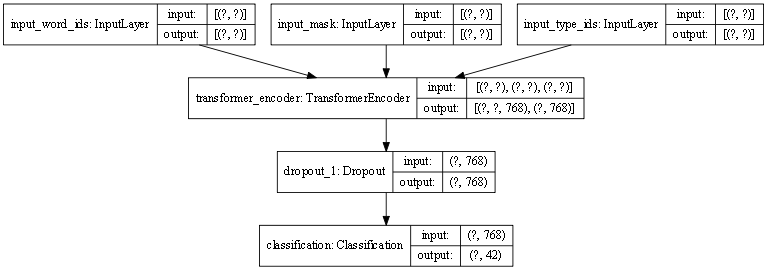

In [21]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=64)

In [22]:
# 데이터 10개의 예제 테스트 배치 (출력은 두 클래스에 대한 로짓)
batch_test = {key: val[:10] for key, val in train.items()}

bert_classifier(batch_test, training=False).numpy() 

array([[-0.0344505 , -0.11114638,  0.1428767 ,  0.17810766,  0.07875197,
         0.02760741,  0.33950835, -0.08632793,  0.20302065, -0.02115559,
        -0.03691394, -0.09617101, -0.06764795,  0.21038279,  0.10227313,
         0.18893313,  0.13592044,  0.13248177,  0.41310567,  0.36595616,
        -0.0100612 , -0.0072171 ,  0.1225303 ,  0.04020089,  0.10800517,
        -0.4931589 , -0.01294426,  0.14735414, -0.02609213,  0.16981211,
        -0.13663292, -0.09994231, -0.1025279 , -0.44676614,  0.34240228,
         0.10552938,  0.06644575,  0.29190922,  0.13290964, -0.25412345,
        -0.19076154, -0.03557288],
       [-0.02971744, -0.11351289,  0.09845264,  0.17206348,  0.14281009,
        -0.02900096,  0.34417436, -0.04630952,  0.20320712, -0.05498802,
        -0.01720022, -0.10082972, -0.06579202,  0.16120456,  0.06335554,
         0.17582974,  0.15044415,  0.20768212,  0.4250434 ,  0.37566775,
        -0.01774197, -0.05093201,  0.11866142,  0.027643  ,  0.06668513,
        -0.45983

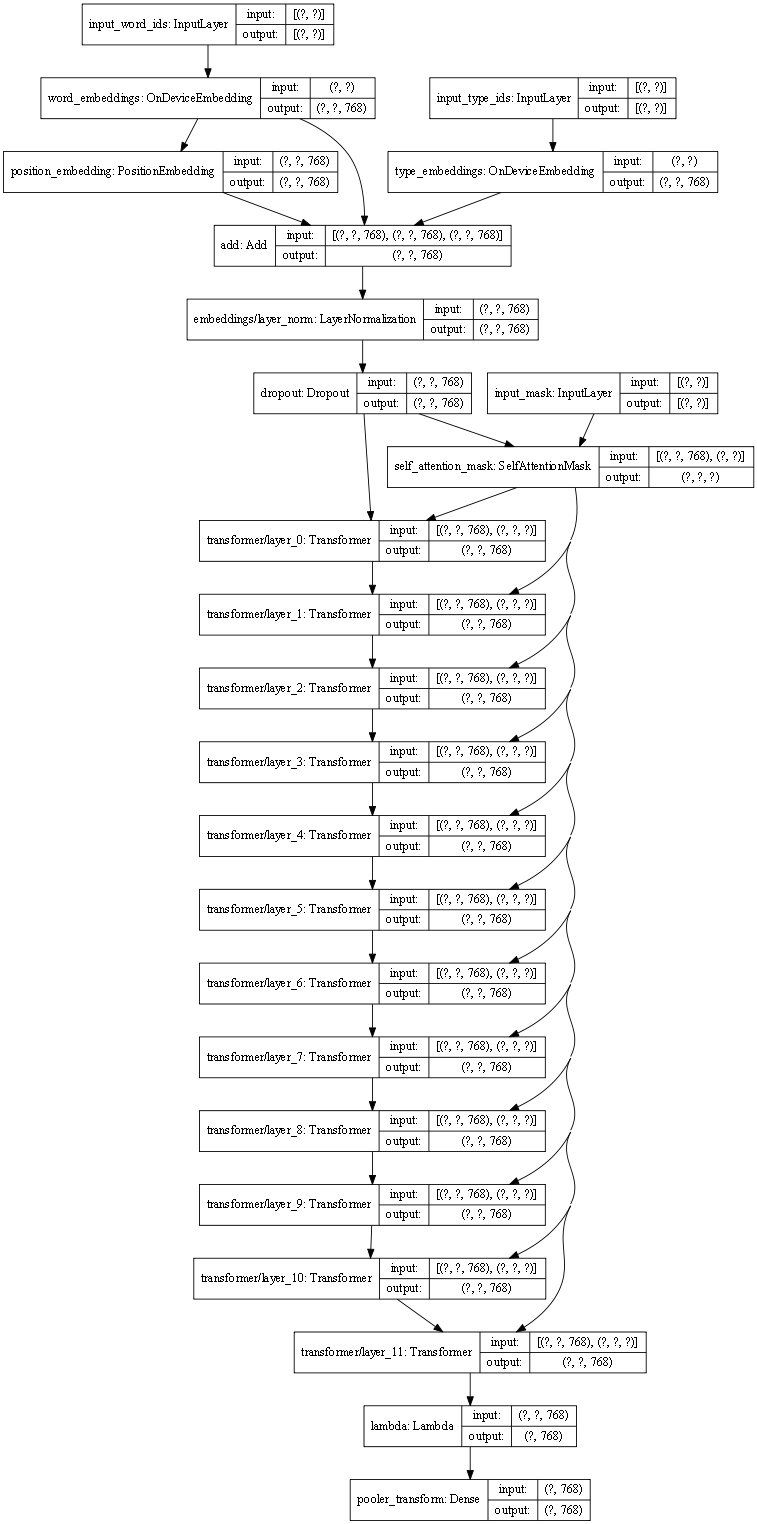

In [23]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=64)

### encoder 가중치 복원!

In [24]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(model_ckpt, 'bert_model.ckpt')).assert_consumed()

### 최적화 프로그램 설정

In [25]:
# BERT는 가중치 감소 ( " AdamW "라고도 함)가있는 Adam 최적화 프로그램을 채택합니다. 또한 먼저 0에서 워밍업 한 다음 0으로 감소하는 학습률 일정을 사용합니다.

# Set up epochs and steps
epochs = epoch
eval_batch_size = batch_size # 32에서 수정

# train_data_size = len(train['label'])
train_data_size = len(train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size) 

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [26]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [27]:
train_data_size

4629

### 로스함수 정의, 할당 및 모델 구조 변경

In [28]:
from tensorflow.keras.layers import Lambda, Dense

if loss_type == 'TRI':
    # 손실 함수 정의 (얘는 따로 정의 안함)
    alpha = 0.3
    
    # 손실 함수 할당
    loss = tfa.losses.TripletHardLoss(margin=alpha)
    
    # 모델 구조 변경 (lambda 층 추가)
    x = bert_encoder.layers[-1].output
    outputs = Lambda(lambda x: tf.math.l2_normalize(x,axis=1))(x)
    bert_encoder_tri = tf.keras.Model(bert_encoder.input, outputs)

    # bert_encoder_tri.summary()
    # type(bert_encoder) 
    
elif loss_type == 'COS_OHOT' or 'COS_OMNS':

    # 손실 함수 정의
    from tensorflow.keras.utils import to_categorical
    from tensorflow.python.ops import math_ops
    from tensorflow.python.ops import nn
    
    def cosine_onehot_loss(y_true, y_pred):
        y_true = nn.l2_normalize(y_true, axis=-1)
        y_pred = nn.l2_normalize(y_pred, axis=-1)
        before_mean = 1-math_ops.reduce_sum(y_true * y_pred, axis=-1)

        #     return math_ops.mean(before_mean,axis=-1)
        return before_mean # 평균 안내봄
    
    # 손실 함수 할당
    loss = cosine_onehot_loss
    
    # 모델 구조 변경 (Dense 층, Lambda 층 추가)
    x = bert_encoder.layers[-1].output
    output_temp = Dense(num_classes, activation=None)(x)

    outputs = Lambda(lambda x: tf.math.l2_normalize(x,axis=1))(output_temp)
    bert_encoder_tri = tf.keras.Model(bert_encoder.input, outputs)

    # bert_encoder_tri.summary()
    # type(bert_encoder)
    
else:
    raise Exception('잘못된 손실 함수 입력')

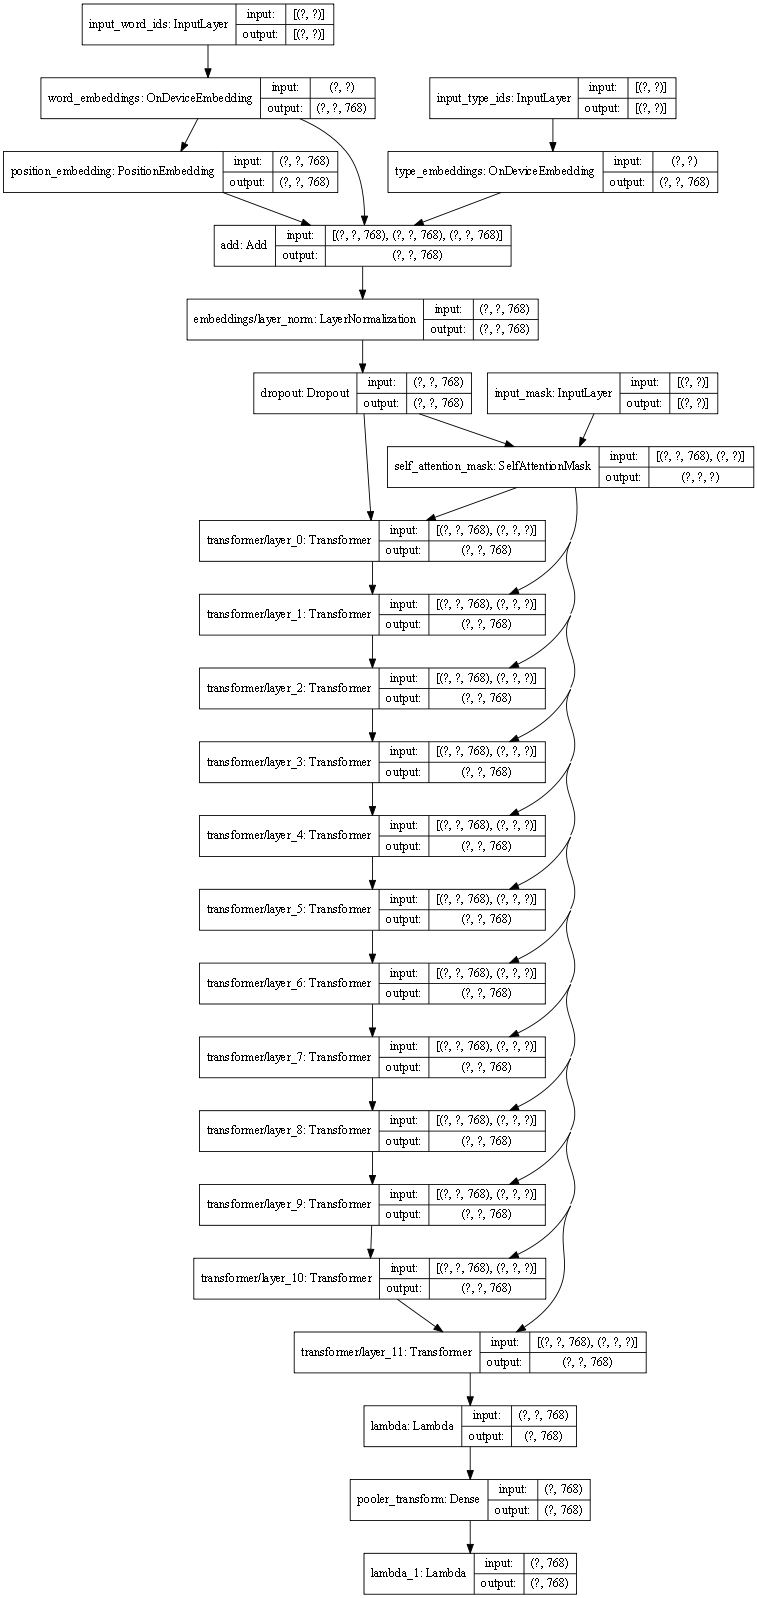

In [29]:
tf.keras.utils.plot_model(bert_encoder_tri, show_shapes=True, dpi=64)

### 모델 훈련

In [30]:
bert_encoder_tri.compile(
    optimizer=optimizer,
    loss=loss)

# train_labels 없으면 안되나
bert_encoder_tri.fit(
      train,train_labels,
      validation_data=(validation, validation_labels),
      batch_size=batch_size,
      epochs=epochs,
      callbacks = [model_tensorboard, CustomCallback()]) 

Epoch 1/40
145/145 [==============================] - 36s 248ms/step - loss: 0.3516 - val_loss: 0.3058
Epoch 2/40
145/145 [==============================] - 33s 230ms/step - loss: 0.3054 - val_loss: 0.2986
Epoch 3/40
145/145 [==============================] - 35s 239ms/step - loss: 0.2960 - val_loss: 0.2865
Epoch 4/40
145/145 [==============================] - 34s 232ms/step - loss: 0.2500 - val_loss: 0.1673
Epoch 5/40
145/145 [==============================] - 34s 237ms/step - loss: 0.1557 - val_loss: 0.1092
Epoch 6/40
145/145 [==============================] - 33s 228ms/step - loss: 0.1052 - val_loss: 0.1113
Epoch 7/40
145/145 [==============================] - 33s 229ms/step - loss: 0.0769 - val_loss: 0.0810
Epoch 8/40
145/145 [==============================] - 34s 232ms/step - loss: 0.0606 - val_loss: 0.0806
Epoch 9/40
145/145 [==============================] - 33s 228ms/step - loss: 0.0464 - val_loss: 0.0728
Epoch 10/40
145/145 [==============================] - 34s 237ms/step - l